# New graph coarsening experiment

## imports and misc

In [1]:
from pathlib import Path
if "experiments" in Path.cwd().parts:
    %cd ..

import logging
import os
import sys
import warnings
import itertools as it
from time import perf_counter
def append_path(s):
    if s in sys.path:
        return
    sys.path.insert(0, s)
    
#You don’t need those lines if you installed the packages
append_path("/home/tristan/research/ot_markov_distances/")
append_path("/home/tristan/research/tb_ml/")
append_path("/home/tristan/research/FGW/lib")
#sys.path.pop(sys.path.index("/home/tristan/research/ot_markov_distances/experiments"))

logging.basicConfig(level=logging.INFO, force=True)

/home/tristan/research/ot_markov_distances


In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm


In [3]:
from skimage.filters import threshold_otsu, threshold_yen

In [4]:
from ot_markov_distances import discounted_wl_infty as wl_reg_infty
from ot_markov_distances.utils import weighted_transition_matrix, draw_markov
from experiments.utils.modules import ParametricMarkovMatrixWithMatchings, ParametricMarkovMatrix, ParametricMarkovMatrixWithLabels
from experiments.utils.data_generation import circle_graph, FGW_build_noisy_circular_graph, add_er_noise, get_label_matrix

%load_ext autoreload
%autoreload 2

In [5]:
append_path("/home/tristan/research/FGW/lib")
from FGW import fgw_barycenters
from graph import Graph as FGW_Graph, graph_colors,draw_rel,draw_transp,find_thresh,sp_to_adjency


In [6]:
logging.basicConfig(level=logging.WARNING, force=True)

## Functions

In [7]:
def grid_init(*args):
    match args:
        case []:
            return None
        case [n0, *tail]:
            return [grid_init(*tail) for _ in range(n0)]

def my_threshold(M):
    median = np.median(M)
    #print(median)
    return 3 * median # why hard when it could be easy

def markov_threshold(M, method=my_threshold):
    threshold = method(M)
    G = nx.from_numpy_array( M> threshold, create_using=nx.DiGraph)
    return G

In [8]:
def opt_loop_batched(target_matrices, 
             n_steps=300, projection_size=5, 
             run_name="barycenter", 
            device = torch.device("cuda:3"), 
             lr=1e-2, 
             weight_decay=0,
             heat=1.,
             matching_heat=1.,
             wl_parameters = dict(delta=.5, sinkhorn_reg=.01, x_is_sparse=False, y_is_sparse=True),
             labels = None,
            time_factor=None, 
            ):
    
    n_targets = len(target_matrices)
    target_sizes = [matrix.shape[0] for matrix in target_matrices]
    target_matrices = [matrix.to(device) for matrix in target_matrices]
    target_matrices_batched = torch.stack(target_matrices, dim=0)
    
    if labels is None:
        projection = ParametricMarkovMatrixWithMatchings(projection_size, 
                                                         *target_sizes, 
                                                         heat=heat,
                                                        matching_heat=matching_heat).to(device)
    else:
        projection = ParametricMarkovMatrixWithLabels(projection_size, *labels, heat=heat, time_factor=time_factor).to(device)
                                        

    target_measures = [
        torch.ones(size, device=device, requires_grad=False) / size
        for size in target_sizes]
    target_measures_batched = torch.stack(target_measures, dim=0)
    
    projection_measure = torch.ones((n_targets, projection_size), device=device, requires_grad=False) / projection_size


    optim = torch.optim.Adam(projection.parameters(), lr=lr, weight_decay=weight_decay)

    writer = SummaryWriter(f"{os.environ['HOME']}/tensorboard/{run_name}")
    parameter_values = []
    losses = []

    for step in trange(n_steps):
        optim.zero_grad()

        M, *Ds = projection()
        batched_Ds = torch.stack(Ds, dim=0)
        batched_M = M.expand(n_targets, -1, -1)
        
        loss = wl_reg_infty(batched_M, 
                            target_matrices_batched, 
                            batched_Ds, 
                            muX=projection_measure,
                            muY=target_measures_batched,
                            **wl_parameters).square().mean(0)
        loss.backward()
        optim.step()


        writer.add_scalar("loss", loss, step) 
        losses.append(loss.item())
        with torch.no_grad():
            markov, *matchings = projection.get()
            parameter_values.append(
                (markov.numpy(force=True), 
                 *(matching.detach().cpu() for matching in matchings)
                )
            )
            
    return projection, parameter_values, losses


## Directed Circle

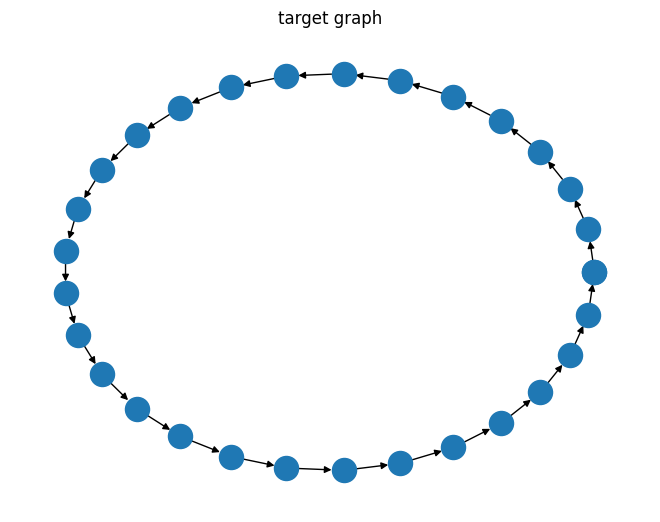

In [23]:
n_target = 30
n_coarsened = 15

def get_oriented_circle(n, doubled_edges=1):
    G = nx.DiGraph()
    angles = np.linspace(0, 2*np.pi, n)
    x = np.cos(angles)
    y = np.sin(angles)
    coords = np.stack([x, y], axis=-1)
    for node_index, node_coords in zip(range(n), coords):
        G.add_node(node_index, attr=node_coords, pos=node_coords)
        for i in range(1, doubled_edges+1):
            G.add_edge((node_index - i) % n, node_index)
    return G


G = get_oriented_circle(n_target)
target_markov = weighted_transition_matrix(G, 0)
target_labels = torch.as_tensor(np.asarray(
        [i for i in nx.get_node_attributes(G, "attr").values()] 
         ), dtype=torch.float32)

nx.draw(G, nx.get_node_attributes(G, "pos"))
plt.title("target graph");

In [21]:
device = torch.device("cuda:1")
target_markov_2 = torch.matrix_power(target_markov, 2)
proj, parameter_values, losses = opt_loop_batched(
        target_markov_2[None, ...],
        labels=target_labels[None, ...],
        projection_size=n_coarsened,
        device=device,
        n_steps=3000,
        heat=1,
        lr=5e-3,
        weight_decay=0,
        run_name=f"circle_coarsening {(run_number:=vars().get('run_number', 0)+1)}",
        wl_parameters = dict(sinkhorn_reg=.05, delta=.5, x_is_sparse=False, y_is_sparse=True),
        #time_factor=2, 
    )


  0%|          | 0/3000 [00:00<?, ?it/s]

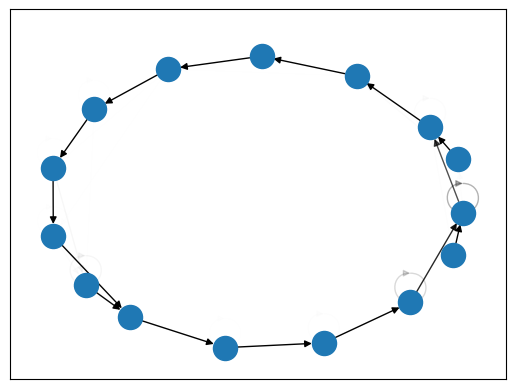

In [22]:
proj.draw()

In [24]:
coarsened_sizes = [5, 10, 15, 20, 25]
  
coarsenings = []

for coarsened_size in coarsened_sizes:
    factor = n_target // coarsened_size
    target_markov_power = torch.matrix_power(target_markov,factor) 
    proj, parameter_values, losses = opt_loop_batched(
        target_markov_power[None, ...],
        labels=target_labels[None, ...],
        projection_size=coarsened_size,
        device=device,
        n_steps=3000,
        heat=1,
        lr=5e-3,
        weight_decay=0,
        run_name=f"circle_coarsening {(run_number:=vars().get('run_number', 0)+1)}",
        wl_parameters = dict(sinkhorn_reg=.05, delta=.5, x_is_sparse=False, y_is_sparse=True),
    )
    coarsenings.append(proj)

    

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

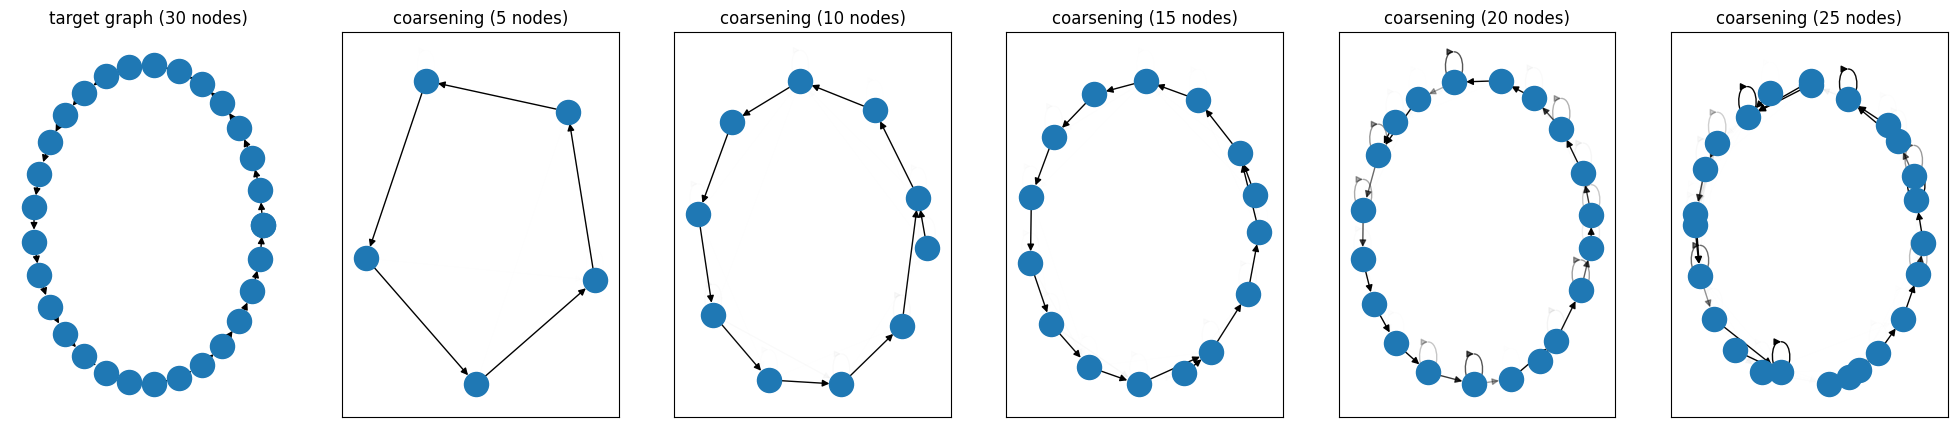

In [25]:
_, axes = plt.subplots(1, len(coarsened_sizes) + 1, figsize =(len(coarsened_sizes)*5, 5))

plt.sca(axes[0])
nx.draw(G, nx.get_node_attributes(G, "pos"))
plt.title(f"target graph ({len(G)} nodes)");

for size, proj, ax in zip(coarsened_sizes, coarsenings, axes[1:]):
    plt.sca(ax)
    proj.draw()
    ax.set_title(f"coarsening ({size} nodes)")


### Partial matrix power

In [30]:
eigenvalues, eigenvectors = torch.linalg.eig(target_markov)
eigenvalues

tensor([-1.0000+0.0000j, -0.9781+0.2079j, -0.9781-0.2079j, -0.9135+0.4067j,
        -0.9135-0.4067j, -0.8090+0.5878j, -0.8090-0.5878j, -0.6691+0.7431j,
        -0.6691-0.7431j, -0.5000+0.8660j, -0.5000-0.8660j, -0.3090+0.9511j,
        -0.3090-0.9511j, -0.1045+0.9945j, -0.1045-0.9945j,  0.1045+0.9945j,
         0.1045-0.9945j,  0.3090+0.9511j,  0.3090-0.9511j,  0.5000+0.8660j,
         0.5000-0.8660j,  0.6691+0.7431j,  0.6691-0.7431j,  1.0000+0.0000j,
         0.9781+0.2079j,  0.9781-0.2079j,  0.8090+0.5878j,  0.8090-0.5878j,
         0.9135+0.4067j,  0.9135-0.4067j])

In [74]:
recup0 = (eigenvectors @ (eigenvalues[:, None]* torch.linalg.inv(eigenvectors))).real



In [76]:
partial_power = eigenvectors @ ((eigenvalues[:, None] ** (2/ 3))* torch.linalg.inv(eigenvectors))

partial_power

tensor([[ 0.4128+0.0289j, -0.1637-0.0289j,  0.8267-0.0289j, -0.2054+0.0289j,
          0.1158-0.0289j, -0.0793+0.0289j,  0.0592-0.0289j, -0.0462+0.0289j,
          0.0369-0.0289j, -0.0299+0.0289j,  0.0242-0.0289j, -0.0195+0.0289j,
          0.0153-0.0289j, -0.0117+0.0289j,  0.0083-0.0289j, -0.0051+0.0289j,
          0.0020-0.0289j,  0.0010+0.0289j, -0.0041-0.0289j,  0.0072+0.0289j,
         -0.0105-0.0289j,  0.0141+0.0289j, -0.0180-0.0289j,  0.0226+0.0289j,
         -0.0279-0.0289j,  0.0344+0.0289j, -0.0428-0.0289j,  0.0543+0.0289j,
         -0.0714-0.0289j,  0.1007+0.0289j],
        [ 0.8267-0.0289j,  0.4128+0.0289j, -0.2054+0.0289j,  0.1158-0.0289j,
         -0.0793+0.0289j,  0.0592-0.0289j, -0.0462+0.0289j,  0.0369-0.0289j,
         -0.0299+0.0289j,  0.0242-0.0289j, -0.0195+0.0289j,  0.0153-0.0289j,
         -0.0117+0.0289j,  0.0083-0.0289j, -0.0051+0.0289j,  0.0020-0.0289j,
          0.0010+0.0289j, -0.0041-0.0289j,  0.0072+0.0289j, -0.0105-0.0289j,
          0.0141+0.0289j, -0.018

## What about the grid?